# Solar Simulation Application with National Solar Radiance Database and System Advisor Models

### Introducing students to:
#### 1. Solar irradiance data along with other important meteorological variables in NSRDB
#### 2. Solar power simulation functionality from System Advisor Models 

### This notebook demonstrates the following process:
- Construct a configuration json file that specify the information in each dataset
- Create dropdown user interface to customize input variables 
- Fetch the urls given input parameters 
- Access the data with the urls through NREL developer API
- Run solar simulation through PySAM modules
- Visualize the results aggregated daily, monthly, and yearly


### Prerequisites:
This notebook assumes the following:
- Understand the dataset in NSRDB through the official website : https://nsrdb.nrel.gov
    * [Different Ways of Accessing NSRDB data.ipynb](https://github.com/HighTechnologyFoundation/HTFCloudFellows/blob/Justin-Lin/Solar%20Simulation%20Analysis/Jupyter%20Notebooks/Different%20Ways%20of%20Accessing%20NSRDB%20data.ipynb) This notebook demonstrates how to access NSRDB data from different sources including: 
        * Azure Blob Storage
        * Google Cloud Storage 
        * AWS S3 Buckets
        * NREL developer API
        * AWS HSDS
    * list the characteristics for different datasets in NSRDB in `DatasetInfo.json` file under `Configuration Files` folder
- Get NSRDB API Key: https://developer.nrel.gov/signup/
    * store the key in `API_Key.json` file under `Configuration Files` folder
- The geographical lat lon information is stored in the `Areas_lat_lon.json` file under `Configuration Files` folder
- The following packages need to be installed into your python environment: 
    - `pandas`  `numpy`  `matplotlib`  `ipywidgets`  `alive_progress`  `nrel-pysam`


In [8]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install ipywidgets
%pip install alive_progress
%pip install nrel-pysam

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.




### References:
- [NSRDB download instructions using API](https://developer.nrel.gov/docs/solar/nsrdb/)
- [PySAM module references](https://nrel-pysam.readthedocs.io/en/main/py-modindex.html)

#### Differences Between DNI, DHI, GHI:
- Direct Normal Irradiance (DNI) is the amount of solar radiation received per unit area by a surface that is always held perpendicular (or normal) to the rays that come in a straight line from the direction of the sun at its current position in the sky. Typically, you can maximize the amount of irradiance annually received by a surface by keeping it normal to incoming radiation. This quantity is of particular interest to concentrating solar thermal installations and installations that track the position of the sun.

- Diffuse Horizontal Irradiance (DHI) is the amount of radiation received per unit area by a surface (not subject to any shade or shadow) that does not arrive on a direct path from the sun, but has been scattered by molecules and particles in the atmosphere and comes equally from all directions.

- Global Horizontal Irradiance (GHI) is the total amount of shortwave radiation received from above by a surface horizontal to the ground. This value is of particular interest to photovoltaic installations and includes both Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DHI).

<div align=center>
<img src="..\SolarIrradianceChart.png" width="600"/>
</div>

---
### Create Dropdown Interfaces

Design GUI components in dropdown format for users to choose the input variables. 

In [9]:
from ipywidgets import interact, Dropdown, Layout

# Formatting settings for drop-down menus
style = {'description_width': '200px'}
layout = Layout(width='325px')

InOutChoice = Dropdown(description = 'Inside or Outside the US', style=style, layout=layout)
Area = Dropdown(description = 'Area:', style=style, layout=layout)
StartYear = Dropdown(description = 'Start Year:', style=style, layout=layout)
EndYear = Dropdown(description = 'End Year:', style=style, layout=layout)
Interval = Dropdown(description = 'Temporal Resolution (in Minutes):', style=style, layout=layout)
Capacity = Dropdown(description = 'Your System Capacity (in MW):', style=style, layout=layout)

### Define relationship between input variables

Create dictionary that specifies the relationship between input variables from the configuration `DatasetInfo.json` file.
- `InOutArea` - Given the option inside or outside the US, what areas are available for users to choose.
- `AllAreaYear` - Given the areas, what is the starting year of the data covered in NSRDB. 

In [10]:
import json
from itertools import product
import pandas as pd
pd.set_option('display.max_columns', None)
from pathlib import Path

ConfigFileDirectory = Path("..") / "Configuration Files"
DatasetInfoFile = "DatasetInfo.json"
AreasLatLonFile = "Areas_lat_lon.json"
ApiKeyFile = "API_Key.json"

with open(ConfigFileDirectory / DatasetInfoFile) as f:
    DatasetInfo = json.load(f)

GeoInfo = pd.read_json(ConfigFileDirectory / AreasLatLonFile)
InUSName = GeoInfo.state.tolist()[:-4]
OutUSName = GeoInfo.state.tolist()[-4:]

InOutArea = {'United States': InUSName, 'International': OutUSName}

OutUSAreaYear = {}
OutUSAreaRes = {}
for key, value in DatasetInfo['OutTheUS'].items():
    OutUSAreaYear[key] = [str(i) for i in range(int(value['StartYear']), int(value['EndYear']) + 1)]
    OutUSAreaRes[key] = value['Resolution']


def Convert(tup, di):
    for a, b in tup:
        di.setdefault(a, []).append(b)
    return di

EmptyDict = {}
from itertools import product
InUSAreaYear = Convert([i for i in product(InUSName, [str(i) for i in range(int(DatasetInfo["InTheUS"]["LowResoluion"]["StartYear"]), int(DatasetInfo["InTheUS"]["LowResoluion"]["EndYear"]) + 1)])], EmptyDict)    


AllAreaYear = OutUSAreaYear | InUSAreaYear

### Create function to fetch urls given user inputs

`get_url_from_NSRDB()` - This function runs a for loop to construct a list of valid URLs following the NSRDB API format.
- Variables that change based on user inputs include : `lat` `lon` `year` `interval` `dataset` `attributes` 


In [19]:
def get_url_from_NSRDB():
    UrlList = []
    global lat, lon
    with open(ConfigFileDirectory / ApiKeyFile) as f:
        Cred = json.load(f)
    
    for year in range(int(StartYear.value), EndYear.value+1):
        # url parameters
        lat = GeoInfo[GeoInfo['state'] == Area.value]['latitude'].values[0]
        lon = GeoInfo[GeoInfo['state'] == Area.value]['longitude'].values[0]
        api_key = Cred["key"]
        interval = str(Interval.value)
        leap_year = 'false'
        utc = 'false'
        your_name = 'Justin+Lin'
        reason_for_use = 'beta+testing'
        your_affiliation = 'HTF'
        your_email = 'slin@wvhtf.org'
        mailing_list = 'false'

        if Area.value not in OutUSName:
            dataset = DatasetInfo['InTheUS']['HighResolution']['Dataset'] if (Interval.value == "5") or (Interval.value == "15") else DatasetInfo['InTheUS']['LowResoluion']['Dataset']
            attributes = DatasetInfo['InTheUS']['HighResolution']['Attributes']
        else:
            dataset = ', '.join(map(str, [v['Dataset'] for k, v in DatasetInfo['OutTheUS'].items() if Area.value == k]))
            attributes = ', '.join(map(str, [v['Attributes'] for k, v in DatasetInfo['OutTheUS'].items() if Area.value == k]))

        url = f"https://developer.nrel.gov/api/nsrdb/v2/solar/{dataset}.csv?"\
                f"wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap_year}&interval={interval}"\
                f"&utc={utc}&full_name={your_name}&email={your_email}&affiliation={your_affiliation}"\
                f"&mailing_list={mailing_list}&reason={reason_for_use}&api_key={api_key}&attributes={attributes}"

        UrlList.append(url)

    return UrlList


### Create function to run solar simulation through PySAM modules

`solar_power_simulation()` - This function does the following:
- read data from the url just created 
- construct a SAM model 
- set parameters for climate information and system configuration 
- execute the model to run simulation to get solar power generation data
- return the combined data for each year
- create a progress bar while running this function. 


In [20]:
import numpy as np
from alive_progress import alive_bar
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import PySAM.PySSC as pssc
from typing import List

def solar_power_simulation(NSRDB_urls:List[str]) -> None:
    global final_data
    appended_data = []
    
    with alive_bar(len(NSRDB_urls), force_tty=True, title='Simulating', length=20, bar = 'smooth') as bar:
        for url in NSRDB_urls:
            info = pd.read_csv(url, nrows=1)
            timezone, elevation = info['Local Time Zone'], info['Elevation']
        
            df = pd.read_csv(url, skiprows=2)

            # SAM Model for solar simulation
            ssc = pssc.PySSC()
            
            # Resource inputs for SAM model:
            # Must be byte strings
            wfd = ssc.data_create()
            ssc.data_set_number(wfd, b'lat', lat)
            ssc.data_set_number(wfd, b'lon', lon)
            ssc.data_set_number(wfd, b'tz', timezone)
            ssc.data_set_number(wfd, b'elev', elevation)
            ssc.data_set_array(wfd, b'year', df['Year'])
            ssc.data_set_array(wfd, b'month', df['Month'])
            ssc.data_set_array(wfd, b'day', df['Day'])
            ssc.data_set_array(wfd, b'hour', df['Hour'])
            ssc.data_set_array(wfd, b'minute', df['Minute'])
            ssc.data_set_array(wfd, b'dn', df['DNI'])
            ssc.data_set_array(wfd, b'df', df['DHI'])
            ssc.data_set_array(wfd, b'wspd', df['Wind Speed'])
            if Area.value == 'Puerto Rico':
                ssc.data_set_array(wfd, b'tdry', df['Air Temperature'])
            else:
                ssc.data_set_array(wfd, b'tdry', df['Temperature'])
        
            # Create SAM compliant object  
            dat = ssc.data_create()
            ssc.data_set_table(dat, b'solar_resource_data', wfd)
            ssc.data_free(wfd)
        
            # Specify the system Configuration
            # Set system capacity in MW
            ssc.data_set_number(dat, b'system_capacity', Capacity.value)
            # Set DC/AC ratio (or power ratio).
            ssc.data_set_number(dat, b'dc_ac_ratio', 1.1)
            # Set tilt of system in degrees
            ssc.data_set_number(dat, b'tilt', 25)
            # Set azimuth angle (in degrees) from north (0 degrees)
            ssc.data_set_number(dat, b'azimuth', 180)
            # Set the inverter efficency
            ssc.data_set_number(dat, b'inv_eff', 96)
            # Set the system losses, in percent
            ssc.data_set_number(dat, b'losses', 14.0757)
            # Specify fixed tilt system (0=Fixed, 1=Fixed Roof, 2=1 Axis Tracker, 3=Backtracted, 4=2 Axis Tracker)
            ssc.data_set_number(dat, b'array_type', 0)
            # Set ground coverage ratio
            ssc.data_set_number(dat, b'gcr', 0.4)
            # Set constant loss adjustment
            ssc.data_set_number(dat, b'adjust:constant', 0)
        
            # execute and put generation results back into dataframe
            mod = ssc.module_create(b'pvwattsv5')
            ssc.module_exec(mod, dat)
            df[b'generation'] = np.array(ssc.data_get_array(dat, b'gen'))
            
            # free the memory
            ssc.data_free(dat)
            ssc.module_free(mod)
            
            appended_data.append(df)

            bar()
        
    final_data = pd.concat(appended_data)
    
    print(f'\033[1mThis dataset has {final_data.shape[0]} rows and {final_data.shape[1]} columns\033[0m')
    return final_data.head(20)

### Create functions to visualize the results 

`daily_plot(df)` - This function creates chart with dual axes to compare daily changes for solar radiance data (GHI, DNI, DHI) and simulated solar generation data given the `final_data` just created. 

In [21]:
from matplotlib import pyplot as plt
plt.style.use('Solarize_Light2')

def daily_plot(df):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    if (Area.value == 'Vietnam') or (Area.value == 'Philippines'):
        df = df.groupby('Hour').sum()[['GHI', 'DNI', 'DHI', b'generation']]
        df[['GHI', 'DNI', 'DHI']].plot(ax=ax, figsize=(15,8), style={'DNI': 'c-o', 'DHI': '-o', 'GHI': 'r-o'}, legend=False)
    else:
        df = df.groupby('Hour').sum()[['GHI', 'DNI', 'DHI', 'Solar Zenith Angle', b'generation']]
        df[['GHI', 'DNI', 'DHI', 'Solar Zenith Angle']].plot(ax=ax, figsize=(15,8), style={'Solar Zenith Angle': 'm-o', 'DNI': 'c-o', 'DHI': 'y-o', 'GHI': 'r-o'}, legend=False)
    df[b'generation'].plot(ax=ax2, style={b'generation': '-D'})
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('kW')
    ax.grid()
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)
    ax.set_xticks([i for i in range(1, 25, 2)])
    if StartYear.value != EndYear.value:
        plt.title(f'Aggregated Daily solar simulation results with {Interval.value} min temporal resolution in {Area.value} from {StartYear.value} to {EndYear.value}')
    else:
        plt.title(f'Aggregated Daily solar simulation results with {Interval.value} min temporal resolution in {Area.value} in {StartYear.value}')


`monthly_plot(df)` - This function creates chart with dual axes to compare monthly changes for solar radiance data (GHI) and simulated solar generation data given the `final_data` just created. 

In [22]:
def monthly_plot(df):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    df = df.groupby('Month').sum()[['GHI', b'generation']]
    df['GHI'].plot(ax=ax, figsize=(15,8), color = 'tab:red', style={'GHI': '-o'}, legend=False)
    df[b'generation'].plot(ax=ax2, style={b'generation': '-D'})
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('kW')
    ax.grid()
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)
    ax.set_xticks(df.index)
    if StartYear.value != EndYear.value:
        plt.title(f'Aggregated Monthly solar simulation results with {Interval.value} min temporal resolution in {Area.value} from {StartYear.value} to {EndYear.value}')
    else:
        plt.title(f'Aggregated Monthly solar simulation results with {Interval.value} min temporal resolution in {Area.value} in {StartYear.value}')

`yearly_plot(df)` - This function creates chart with dual axes to compare yearly changes for solar radiance data (GHI) and simulated solar generation data given the `final_data` just created. 

In [23]:
def yearly_plot(df):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    df = df.groupby('Year').sum()[['GHI', b'generation']]
    df['GHI'].plot(ax=ax, figsize=(15,8), color = 'tab:red', style = {'GHI' : '-o'}, legend=False)
    df[b'generation'].plot(ax=ax2, style={b'generation': '-D'})
    ax.grid()
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('kW')
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)
    ax.set_xticks(df.index)
    if StartYear.value != EndYear.value:
        plt.title(f'Aggregated Yearly solar simulation results with {Interval.value} min temporal resolution in {Area.value} from {StartYear.value} to {EndYear.value}')
    else:
        plt.title(f'Aggregated Yearly solar simulation results with {Interval.value} min temporal resolution in {Area.value} in {StartYear.value}')

---
### User Interface for parameters input

`display_interface()` - This function displays the interactive user interface for people to choose differrent parameters following the order of:
- `InOutChoice`
- `Area`
- `StartYear`
- `EndYear`
- `Interval`
- `Capacity` 

In [24]:
@interact(inout = InOutChoice, area = Area, start = StartYear, end = EndYear, interval = Interval, capacity = Capacity)
def display_interface(inout, area, start, end, interval, capacity):
    try:
        InOutChoice.options = ['United States', 'International']
        Area.options = InOutArea[inout]
        StartYear.options = AllAreaYear[Area.value]
        EndYear.options = [i for i in range(int(StartYear.value), int(AllAreaYear[Area.value][-1]) + 1)]
        if (StartYear.value >= DatasetInfo['InTheUS']['HighResolution']['StartYear']) and (inout == 'United States'):
            resolution = DatasetInfo["InTheUS"]["HighResolution"]["Resolution"]
        elif inout == 'United States':
            resolution = DatasetInfo["InTheUS"]["LowResoluion"]["Resolution"]
        else:
            resolution = OutUSAreaRes[Area.value]
        Interval.options = resolution
        Capacity.options = [i / 10 for i in range(1, 101)]
        
        print(inout, area, start, end, interval, capacity)
    
    except KeyError:
        print('Please choose an area')
    except TypeError: 
        print('Please choose a start year')

interactive(children=(Dropdown(description='Inside or Outside the US', layout=Layout(width='325px'), options=(…

### Fetch urls 

In [25]:
get_url_from_NSRDB()

['https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-2-2-download.csv?wkt=POINT(-105.3272%2039.0646)&names=1999&leap_day=false&interval=60&utc=false&full_name=Justin+Lin&email=slin@wvhtf.org&affiliation=HTF&mailing_list=false&reason=beta+testing&api_key=2aD0f1cpYYogKvIhgzCCEsuBHnVvfGhcaItjJnAU&attributes=ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle',
 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-2-2-download.csv?wkt=POINT(-105.3272%2039.0646)&names=2000&leap_day=false&interval=60&utc=false&full_name=Justin+Lin&email=slin@wvhtf.org&affiliation=HTF&mailing_list=false&reason=beta+testing&api_key=2aD0f1cpYYogKvIhgzCCEsuBHnVvfGhcaItjJnAU&attributes=ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle']

### Run simulations

In [26]:
solar_power_simulation()

Simulating |████████████████████| 2/2 [100%] in 13.3s (0.11/s)                  
This dataset has 17520 rows and 12 columns


,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle,b'generation'
0,1999,1,1,0,30,0,0,0,2.1,-4.6,163.10,0.000000
1,1999,1,1,1,30,0,0,0,2.3,-4.6,155.81,0.000000
2,1999,1,1,2,30,0,0,0,2.3,-4.4,145.31,0.000000
3,1999,1,1,3,30,0,0,0,2.3,-4.1,133.87,0.000000
4,1999,1,1,4,30,0,0,0,2.2,-4.0,122.24,0.000000
5,1999,1,1,5,30,0,0,0,2.3,-4.0,110.75,0.000000
6,1999,1,1,6,30,0,0,0,2.4,-4.0,99.66,0.000000
7,1999,1,1,7,30,4,4,0,3.2,-3.3,88.93,0.000000
8,1999,1,1,8,30,137,47,501,4.6,-1.6,79.74,0.421735
9,1999,1,1,9,30,271,81,608,5.8,-0.1,71.80,0.719459


### Visualization for the simulation results aggregated daily, monthly, and yearly

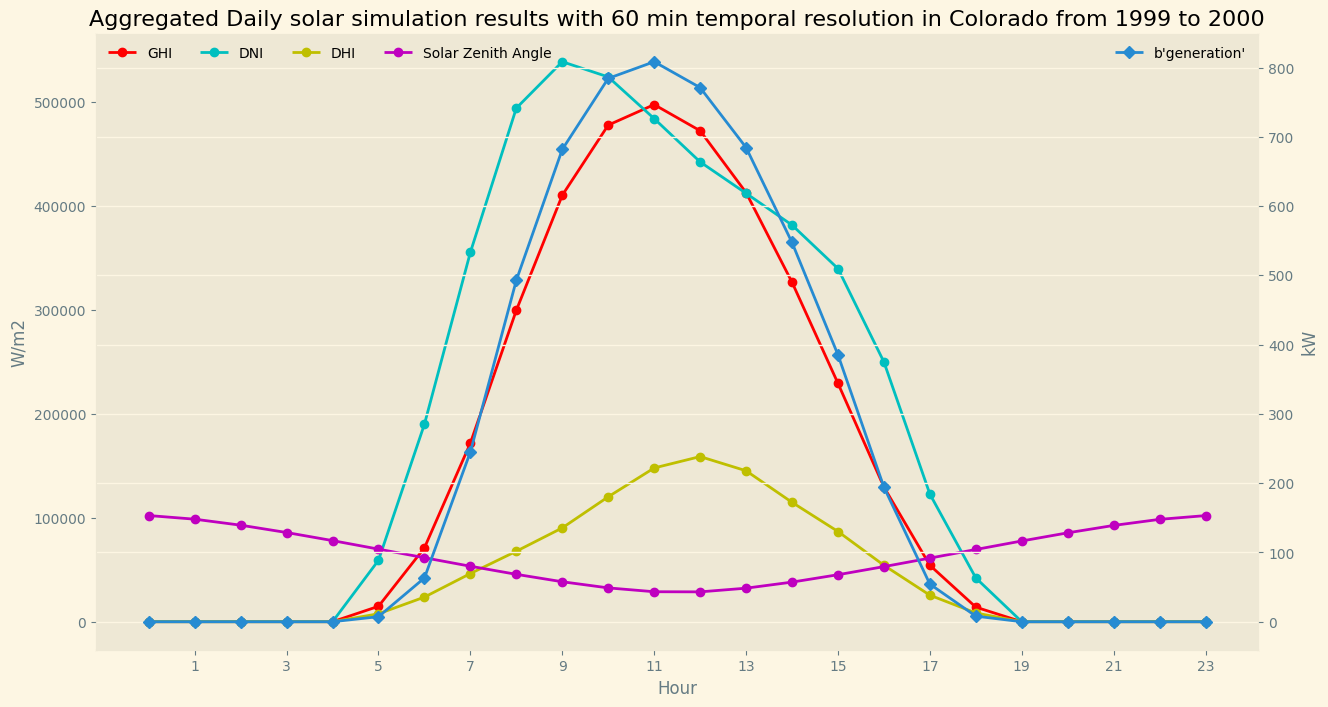

In [27]:
daily_plot(final_data)

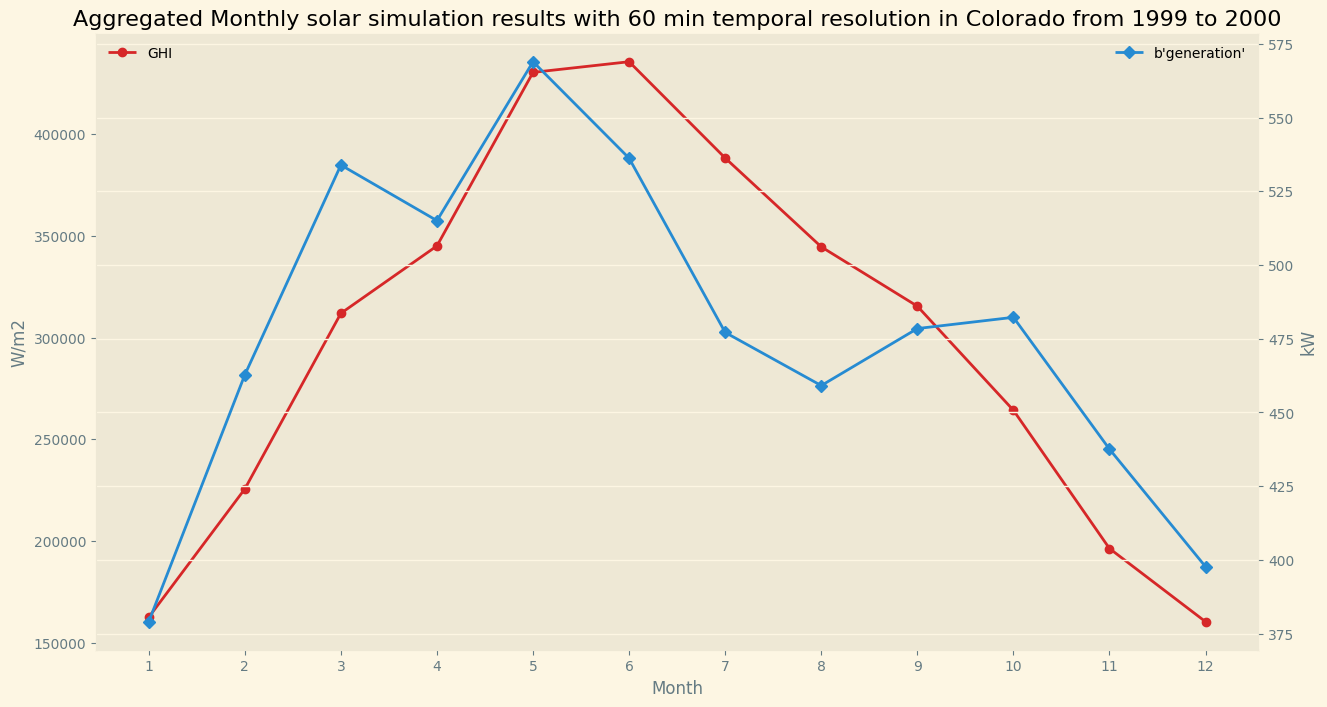

In [28]:
monthly_plot(final_data)

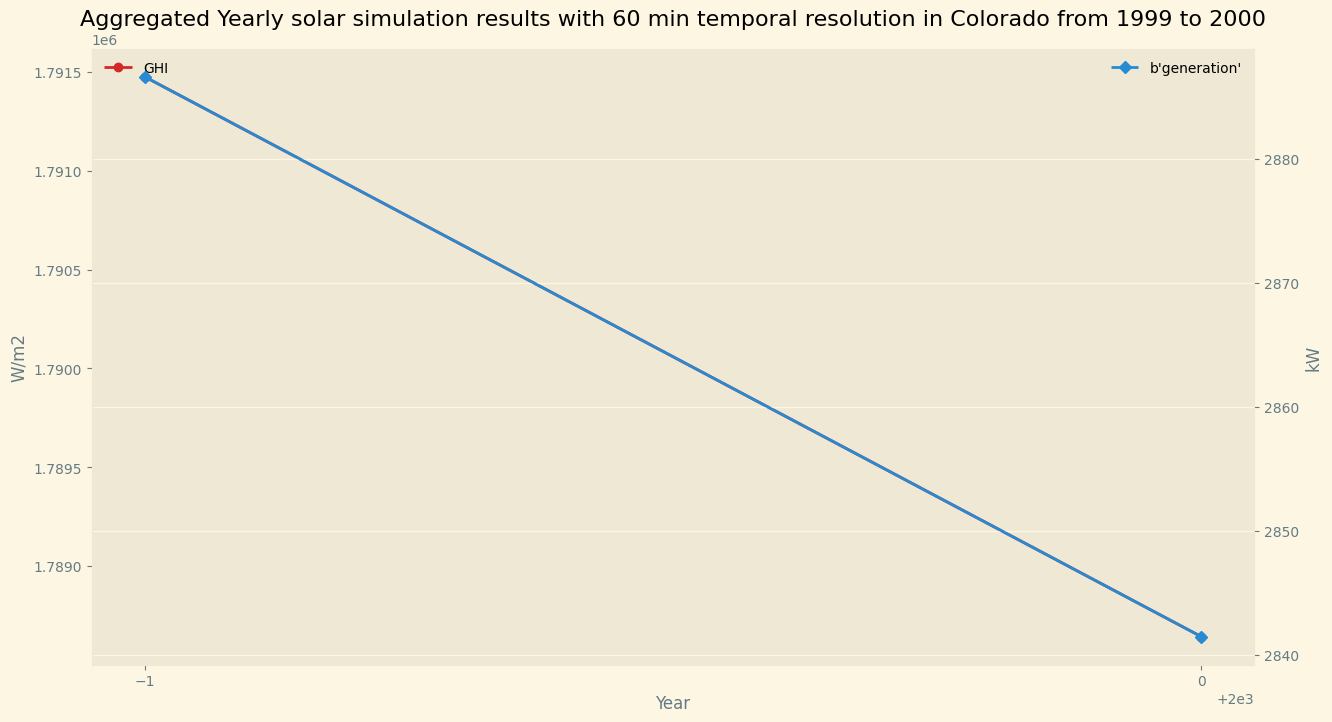

In [29]:
yearly_plot(final_data)